In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
# import umap

from esn_lib.esn import *
from esn_lib.hubesn import *
from esn_tasks.mackey_glass.mackey import *
from esn_tasks.mnist.mnist_28 import *
from esn_tasks.narma10.narma10 import *

In [3]:
PLTPATH = f'../plots/dimensionality'

In [2]:
def get_normalized_readout(model, task, params):
    """
    Returns normalized readout weights and degrees of the reservoir
    """
    esn = HubESN(**params) if model == 'hubesn' else ESN(**params)
    esn.fit(task.X_train, task.y_train)
    _, states = esn.predict(task.X_test)
    mag = np.abs(states.mean(axis=0))
    W_ro = np.abs(esn.W_ro.flatten())
    deg = esn.get_degrees()
    
    delete_idx = np.where(mag < 5e-7)[0]
    mag = np.delete(mag, delete_idx)
    W_ro = np.delete(W_ro, delete_idx) * mag
    deg = np.delete(deg, delete_idx)
    
    return W_ro, deg

def get_readout(model, task, params):
    """
    Returns normalized readout weights and degrees of the reservoir
    """
    esn = HubESN(**params) if model == 'hubesn' else ESN(**params)
    esn.fit(task.X_train, task.y_train)
    W_ro = np.abs(esn.W_ro.flatten())
    
    return W_ro

In [3]:
def plot_weight_deg_correlation(task, params):
    font_scale = 2.5
    size = 19
    alpha = 0.6
    # begin plotting
    sns.set_style('whitegrid')
    sns.set_context('paper', font_scale=font_scale)
    sns.set_color_codes("bright")
    colors = sns.color_palette("Set2")
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    W_ro, deg = get_normalized_readout('esn', task, params)
    corr = np.corrcoef(W_ro, deg)[0, 1]
    axs[0].scatter(deg, W_ro, s=size, alpha=alpha, color=colors[0])
    axs[0].set_xlabel('Degree')
    axs[0].set_ylabel('Weight')
    axs[0].set_title(f"ESN (corr={corr:.3f})")

    W_ro, deg = get_normalized_readout('hubesn', task, params)
    axs[1].scatter(deg, W_ro, s=size, alpha=alpha, color=colors[2])
    axs[1].set_xlabel('Degree')

    deg = (deg - np.min(deg)) / (np.max(deg) - np.min(deg))
    W_ro = (W_ro - np.min(W_ro)) / (np.max(W_ro) - np.min(W_ro))
    corr = np.corrcoef(W_ro, deg)[0, 1]
    axs[1].set_title(f"HubESN (corr={corr:.3f})")

    if np.max(W_ro) > 1e3:
        axs[0].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
        axs[1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    plt.tight_layout()
    plt.savefig(f"{PLTPATH}/weight_deg_correlation_{params['input_neurons']}.png", dpi=300)
    plt.show()

/Users/zhaoze/Library/Mobile Documents/com~apple~CloudDocs/NIPS_2023/Codes/HubESN_neurips/experiments/../esn_tasks/narma10/narma10.py:35: RuntimeWarning: overflow encountered in scalar multiply
  y[t] = 0.3*y[t-1] + 0.05*y[t-1]*np.sum(y[t-10:t]) + 1.5*u[t-10]*u[t-1] + 0.1


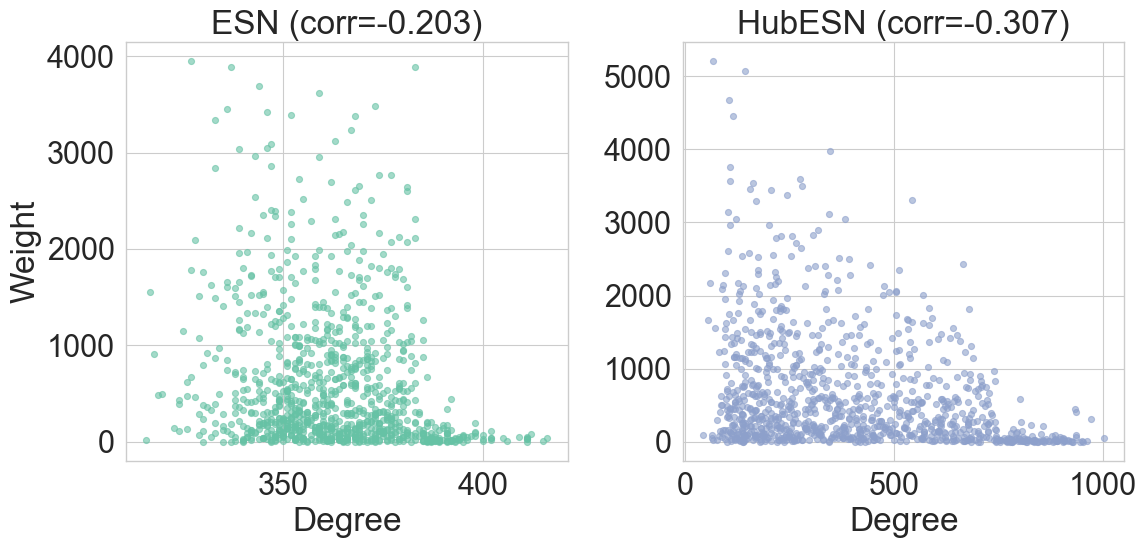

In [12]:
esn_pm = {
    'lr': 0.5,
    'p2': 0.2,
    'r_sig': 0.1,
    'n_size': 1000,
    'spec_rad': 0.9,
    'in_features': 1,
    'in_scale': 1,
    'activation': 'tanh',
    'input_neurons': 'hub',
    'hub_type': 'mix',
    'use_skip': False,
    'verbose': False,
    'lambda_dc': 0.5,
    'lambda_sc': 0.5,
    'exp_coef': 2,
}

task_pm = {
    'n_train': 4000,
    'n_test': 2000,
}
# task = MackeyGlass(**task_pm)
# task = MNIST28(**task_pm)
task = NARMA10(**task_pm)

plot_weight_deg_correlation(task, esn_pm)

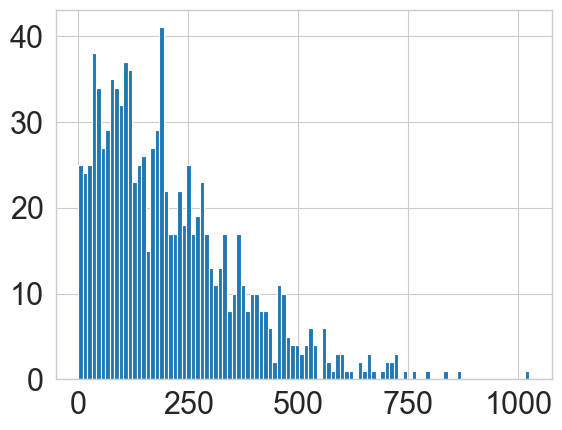

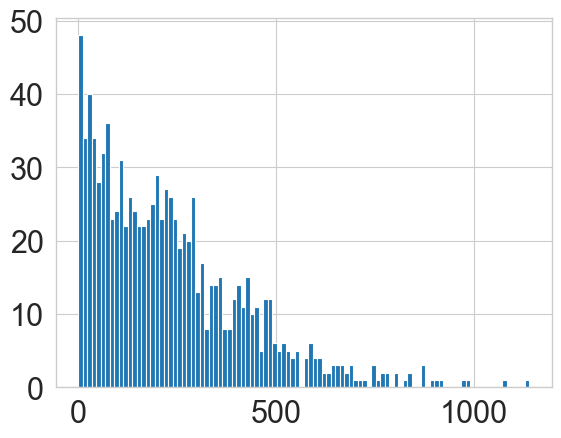

In [28]:
task_pm = {
    'n_train': 500,
    'n_test': 2000,
}
mg = MackeyGlass(**task_pm)
W_ro = get_readout('esn', mg, esn_pm)
plt.hist(W_ro, bins=100)
plt.show()
W_ro = get_readout('hubesn', mg, esn_pm)
plt.hist(W_ro, bins=100)
plt.show()

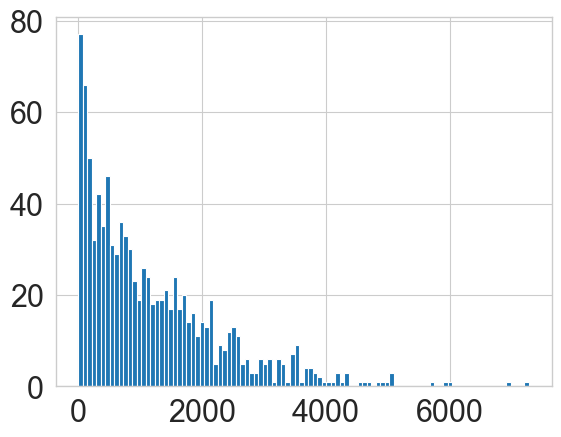

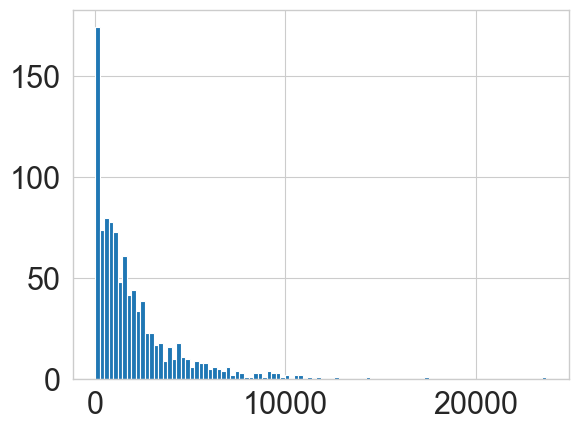

In [29]:
task_pm = {
    'n_train': 2000,
    'n_test': 2000,
}
mg = MackeyGlass(**task_pm)
W_ro = get_readout('esn', mg, esn_pm)
plt.hist(W_ro, bins=100)
plt.show()
W_ro = get_readout('hubesn', mg, esn_pm)
plt.hist(W_ro, bins=100)
plt.show()

In [30]:
W_ro.shape

(1000,)

In [16]:
def plot_tSNE(model, task, params):
    esn = HubESN(**params) if model == 'hubesn' else ESN(**params)
    esn.fit(task.X_train, task.y_train)
    _, states = esn.predict(task.X_test)
    mag = np.abs(states.mean(axis=0))
    W_ro = np.abs(esn.W_ro.flatten())
    
    delete_idx = np.where(mag < 1e-2)[0]
    mag = np.delete(mag, delete_idx)
    W_ro = np.delete(W_ro, delete_idx) / mag
    deg = np.delete(esn.get_degrees(), delete_idx)
    states = np.delete(states, delete_idx, axis=1)
    
    states = StandardScaler().fit_transform(states)

    tsne = TSNE(n_components=2, perplexity=30, n_iter=1000)
    X_embedded = tsne.fit_transform(states.T)

    # W_ro = np.log(W_ro)
    # W_ro = (W_ro + deg) / 2
    W_ro = (W_ro - W_ro.min()) / (W_ro.max() - W_ro.min())
    deg =  ((deg - deg.min()) / (deg.max() - deg.min()))

    n_show = 100
    ro_idx = np.argsort(W_ro)[-n_show:]
    W_ro = W_ro[ro_idx]

    deg_idx = np.argsort(deg)[-n_show:]
    deg = deg[deg_idx]

    W_ro = (W_ro - W_ro.min()) / (W_ro.max() - W_ro.min())
    deg =  (deg - deg.min()) / (deg.max() - deg.min())
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    # axs[0].scatter(X_embedded[ro_idx, 0], X_embedded[ro_idx, 1], s=10, alpha=0.5, cmap='Reds', c=W_ro)
    # axs[1].scatter(X_embedded[deg_idx, 0], X_embedded[deg_idx, 1], s=10, alpha=0.5, cmap='Greens', c=deg)
    axs[0].scatter(X_embedded[ro_idx, 0], X_embedded[ro_idx, 1], s=10, alpha=0.5, color='red')
    axs[0].scatter(X_embedded[deg_idx, 0], X_embedded[deg_idx, 1], s=10, alpha=0.5, color='green')
    plt.show()

plot_tSNE('esn', mg, params)
plot_tSNE('hubesn', mg, params)

NameError: name 'params' is not defined

## Pair-wise Corr

In [446]:
params = {
    'lr': 0.5,
    'p2': 0.2,
    'r_sig': 0.1,
    'n_size': 500,
    'spec_rad': 0.9,
    'in_features': 1,
    'in_scale': 1,
    'activation': 'tanh',
    'input_neurons': 'hub',
    'hub_type': 'mix',
    'use_skip': False,
    'verbose': False,
    'lambda_dc': 0.5,
    'lambda_sc': 0.5,
    'exp_coef': 2,
}

EXPTPATH = f"../results/info_propagation/dim_reduce_{params['input_neurons']}"
PLTPATH = f'../plots/info_propagation'

task_pm = {
    'n_train': 2000,
    'n_test': 2000,
}
mg = MackeyGlass(**task_pm)

(500,)


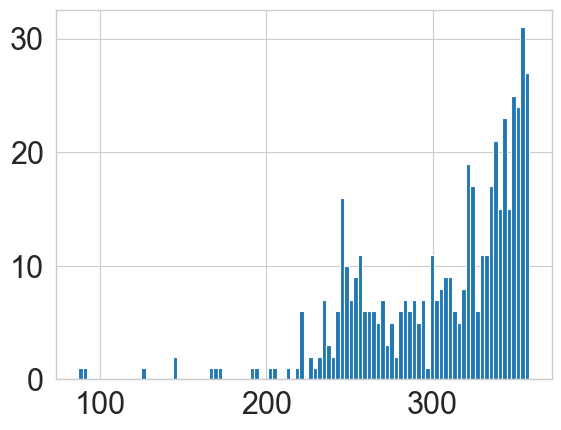

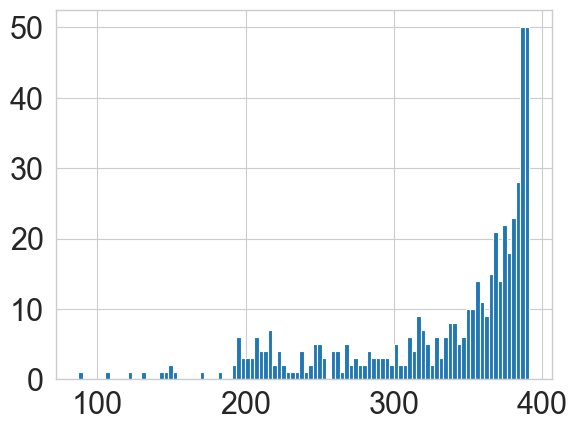

In [478]:
def get_pairwise_corr(model, task, params):
    """
    Returns pairwise correlation between reservoir neurons
    """
    esn = HubESN(**params) if model == 'hubesn' else ESN(**params)
    esn.fit(task.X_train, task.y_train)
    _, states = esn.predict(task.X_test)

    states = StandardScaler().fit_transform(states)
    corr = np.corrcoef(states.T)
    return corr

corr = np.abs(get_pairwise_corr('hubesn', mg, params))
# corr = get_pairwise_corr('hubesn', mg, params)
# get the sum of the upper triangle
corr = np.triu(corr, k=1)
corr_sum = corr.sum(axis=0) + corr.sum(axis=1)
print(corr_sum.shape)
plt.hist(corr_sum, bins=100)
plt.show()
# plt.imshow(corr, cmap='hot', interpolation='nearest')
# plt.colorbar()
# plt.show()

corr = np.abs(get_pairwise_corr('esn', mg, params))
# corr = get_pairwise_corr('esn', mg, params)
corr = np.triu(corr, k=1)
corr_sum = corr.sum(axis=0) + corr.sum(axis=1)
plt.hist(corr_sum, bins=100)
plt.show()
# plt.imshow(corr, cmap='hot', interpolation='nearest')
# plt.colorbar()
# plt.show()

In [431]:
def get_averaged_states(model, task, params, norm, n_runs=10):
    """
    Returns averaged reservoir states and degrees
    @param model: 'esn' or 'hubesn'
    @param task: task object
    @param params: parameters for the model
    @param norm: True if normalize degrees to [0, 1], False otherwise
    @param n_runs: number of runs to average over
    @return states: averaged reservoir states, first r_sig * n_size are input neurons, the rest are non-input neurons
    @return deg: averaged degrees, first r_sig * n_size are input neurons, the rest are non-input neurons
    """
    in_states, nonin_states = [], []
    in_deg, nonin_deg = [], []
    for _ in range(n_runs):
        esn = HubESN(**params) if model == 'hubesn' else ESN(**params)
        esn.fit(task.X_train, task.y_train)
        _, s = esn.predict(task.X_test)
        deg = esn.get_degrees(norm)

        nonin_idx = np.setdiff1d(np.arange(esn.n_size), esn.in_idx)
        in_states.append(s[:, esn.in_idx])
        nonin_states.append(s[:, nonin_idx])
        in_deg.append(deg[esn.in_idx])
        nonin_deg.append(deg[nonin_idx])
    
    in_states = np.array(in_states).mean(axis=0)
    nonin_states = np.array(nonin_states).mean(axis=0)
    in_deg = np.array(in_deg).mean(axis=0)
    nonin_deg = np.array(nonin_deg).mean(axis=0)

    # combine input and non-input neurons
    states = np.hstack((in_states, nonin_states))
    deg = np.hstack((in_deg, nonin_deg))
    scaled_states = StandardScaler().fit_transform(states) # (n_steps, n_neurons), normalize each neuron
    
    return scaled_states, deg

In [366]:
def plot_nodal_repr(hub_states, hub_deg, esn_states, esn_deg, params, cmap, display='2d'):
    # begin plotting
    sns.set_style('white')
    sns.set_context('paper', font_scale=2.5)
    sns.set_color_codes("bright")
    if display == '2d':
        # plot in 3D
        fig = plt.figure(figsize=(12, 6))
        ax = fig.add_subplot(121, projection='3d')
        ax.scatter(hub_states[:, 0], hub_states[:, 1], hub_states[:, 2], s=10, alpha=0.6, c=hub_deg, cmap=cmap)
        ax.set_title(f"HubESN-{params['input_neurons']}")
        ax = fig.add_subplot(122, projection='3d')
        ax.scatter(esn_states[:, 0], esn_states[:, 1], esn_states[:, 2], s=10, alpha=0.6, c=esn_deg, cmap=cmap)
        ax.set_title(f"ESN-{params['input_neurons']}")
        for ax in fig.axes:
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_zticks([])
    else:
        fig = plt.figure(figsize=(12, 6))
        ax = fig.add_subplot(121)
        ax.scatter(hub_states[:, 0], hub_states[:, 1], s=10, alpha=0.6, c=hub_deg, cmap=cmap)
        ax.set_title(f"HubESN-{params['input_neurons']}")
        ax = fig.add_subplot(122)
        ax.scatter(esn_states[:, 0], esn_states[:, 1], s=10, alpha=0.6, c=esn_deg, cmap=cmap)
        ax.set_title(f"ESN-{params['input_neurons']}")
        for ax in fig.axes:
            ax.set_xticks([])
            ax.set_yticks([])

    plt.tight_layout()
    # plt.savefig(f"{PLTPATH}/tSNE_{params['input_neurons']}_{display}.jpg", dpi=300)
    plt.show()

def plot_temporal_repr(hub_in_states, esn_in_states, hub_nonin_states, esn_nonin_states, params, display='2d'):
    alpha = 0.6
    # begin plotting
    sns.set_style('white')
    sns.set_context('paper', font_scale=2.5)
    sns.set_color_codes("bright")
    colors = sns.color_palette("Set3")
    if display == '3d':
        # plot in 3D
        fig, axs = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': '3d'})
        axs[0].plot(hub_in_states[:, 0], hub_in_states[:, 1], hub_in_states[:, 2], alpha=alpha, c=colors[4])
        axs[0].plot(hub_nonin_states[:, 0], hub_nonin_states[:, 1], hub_nonin_states[:, 2], alpha=alpha, c=colors[5])
        axs[0].set_title(f"HubESN-{params['input_neurons']}")
        axs[1].plot(esn_in_states[:, 0], esn_in_states[:, 1], esn_in_states[:, 2], alpha=alpha, c=colors[4])
        axs[1].plot(esn_nonin_states[:, 0], esn_nonin_states[:, 1], esn_nonin_states[:, 2], alpha=alpha, c=colors[5])
        axs[1].set_title(f"ESN-{params['input_neurons']}")
        for ax in fig.axes:
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_zticks([])
    else:
        fig, axs = plt.subplots(1, 2, figsize=(12, 6))
        axs[0].plot(hub_in_states[:, 0], hub_in_states[:, 1], alpha=alpha, c=colors[4])
        axs[0].plot(hub_nonin_states[:, 0], hub_nonin_states[:, 1], alpha=alpha, c=colors[5])
        axs[0].set_title(f"HubESN-{params['input_neurons']}")
        axs[1].plot(esn_in_states[:, 0], esn_in_states[:, 1], alpha=alpha, c=colors[4])
        axs[1].plot(esn_nonin_states[:, 0], esn_nonin_states[:, 1], alpha=alpha, c=colors[5])
        axs[1].set_title(f"ESN-{params['input_neurons']}")
        for ax in fig.axes:
            ax.set_xticks([])
            ax.set_yticks([])

    plt.tight_layout()
    # plt.savefig(f"{PLTPATH}/tSNE_{params['input_neurons']}_{display}.jpg", dpi=300)
    plt.show()

def plot_repr(
        task, 
        params,
        mode='nodal',
        method='tsne', 
        n_runs=10, 
        deg='norm'
        ):
    if method == 'tsne':
        reducer = TSNE(n_components=3, random_state=0)
    elif method == 'pca':
        reducer = PCA(n_components=3)
    elif method == 'umap':
        reducer = umap.UMAP(n_components=3, random_state=0)

    norm = True if deg == 'norm' else False
    hub_states, hub_degrees = get_averaged_states('hub', task, params, norm, n_runs)
    esn_states, esn_degrees = get_averaged_states('esn', task, params, norm, n_runs)

    if mode == 'nodal':
        hub_states = reducer.fit_transform(hub_states.T) # (n_neurons, n_components)
        esn_states = reducer.fit_transform(esn_states.T) # (n_neurons, n_components)
        if deg == 'bin':
            hub_degrees = np.zeros(params['n_size'])
            hub_degrees[:int(params['r_sig'] * params['n_size'])] = 1
            esn_degrees = np.zeros(params['n_size'])
            esn_degrees[:int(params['r_sig'] * params['n_size'])] = 1
            cmap = 'bwr'
        else:
            cmap = 'Reds'
        plot_nodal_repr(hub_states, hub_degrees, esn_states, esn_degrees, esn_pm, cmap, display='3d')
        plot_nodal_repr(hub_states, hub_degrees, esn_states, esn_degrees, esn_pm, cmap, display='2d')
    elif mode == 'temporal':
        hub_states = hub_states[100:]
        esn_states = esn_states[100:]
        n_in = int(params['r_sig'] * params['n_size'])
        hub_in_states = hub_states[:, :n_in]
        hub_nonin_states = hub_states[:, n_in:]
        esn_in_states = esn_states[:, :n_in]
        esn_nonin_states = esn_states[:, n_in:]
        hub_in_states = reducer.fit_transform(hub_in_states)
        hub_nonin_states = reducer.fit_transform(hub_nonin_states)
        esn_in_states = reducer.fit_transform(esn_in_states)
        esn_nonin_states = reducer.fit_transform(esn_nonin_states)
        # scale in_states and nonin_states to the same range
        hub_in_states = StandardScaler().fit_transform(hub_in_states)
        hub_nonin_states = StandardScaler().fit_transform(hub_nonin_states)
        esn_in_states = StandardScaler().fit_transform(esn_in_states)
        esn_nonin_states = StandardScaler().fit_transform(esn_nonin_states)
        # flip if in_states and nonin_states are in opposite directions
        for i in range(3):
            if (hub_in_states[:, i] * hub_nonin_states[:, i]).sum() < 0:
                hub_in_states[:, i] *= -1
            if (esn_in_states[:, i] * esn_nonin_states[:, i]).sum() < 0:
                esn_in_states[:, i] *= -1
        print('HubESN', np.mean((hub_in_states - hub_nonin_states)**2))
        print('ESN', np.mean((esn_in_states - esn_nonin_states)**2))
        plot_temporal_repr(hub_in_states, esn_in_states, hub_nonin_states, esn_nonin_states, params, display='3d')
        plot_temporal_repr(hub_in_states, esn_in_states, hub_nonin_states, esn_nonin_states, params, display='2d')

HubESN 0.48944662296905167
ESN 0.37481646210857417


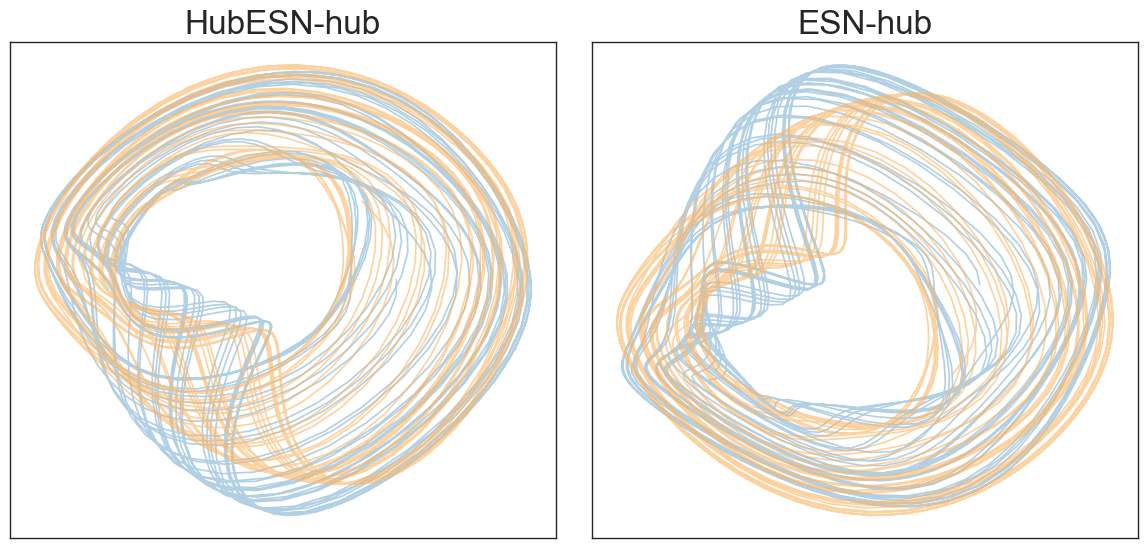

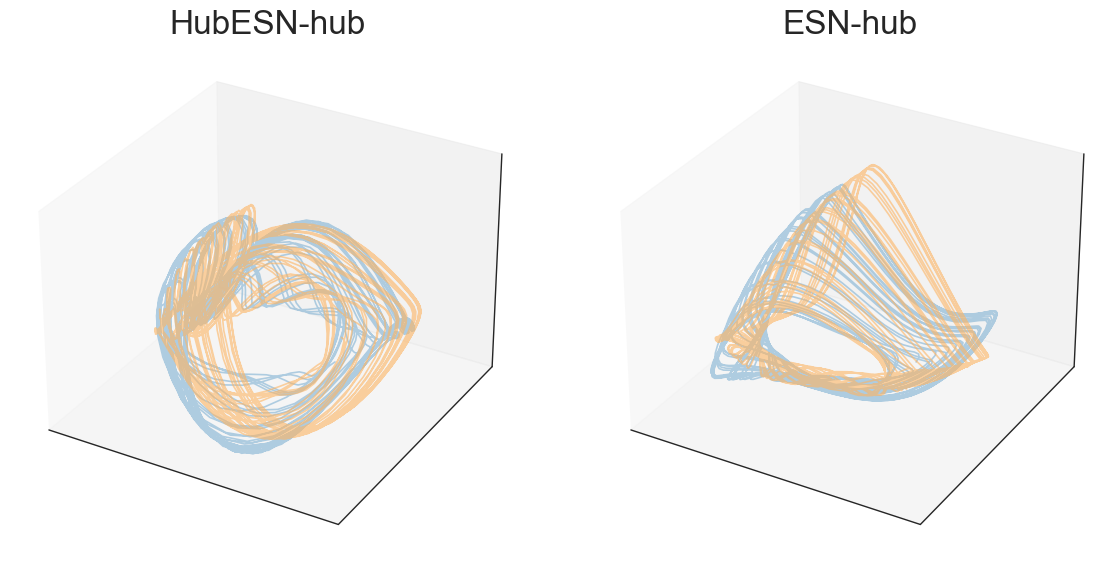

In [376]:
esn_pm = {
    'lr': 0.5,
    'p2': 0.2,
    'r_sig': 0.1,
    'n_size': 500,
    'spec_rad': 0.9,
    'in_features': 1,
    'in_scale': 1,
    'activation': 'tanh',
    'input_neurons': 'hub',
    'hub_type': 'mix',
    'use_skip': False,
    'verbose': False,
    'lambda_dc': 0.5,
    'lambda_sc': 0.5,
    'exp_coef': 2,
}

task_pm = {
    'n_train': 500,
    'n_test': 2000,
}
mg = MackeyGlass(**task_pm)

plot_repr(mg, esn_pm, 'temporal', 'pca', 50, 'bin')

In [392]:
esn_pm = {
    'lr': 0.5,
    'p2': 0.2,
    'r_sig': 0.1,
    'n_size': 500,
    'spec_rad': 0.9,
    'in_features': 1,
    'in_scale': 1,
    'activation': 'tanh',
    'input_neurons': 'hub',
    'hub_type': 'mix',
    'use_skip': False,
    'verbose': False,
    'lambda_dc': 0.5,
    'lambda_sc': 0.5,
    'exp_coef': 2,
}

task_pm = {
    'n_train': 500,
    'n_test': 2000,
}
mg = MackeyGlass(**task_pm)

esn_in_states, esn_nonin_states = get_PCA('esn', mg, esn_pm)
hub_in_states, hub_nonin_states = get_PCA('hubesn', mg, esn_pm)
print(((esn_in_states - esn_nonin_states)**2).mean())
print(((hub_in_states - hub_nonin_states)**2).mean())
# plot_PCA(esn_in_states, esn_nonin_states, hub_in_states, hub_nonin_states, esn_pm, display='2d')
# plot_PCA(esn_in_states, esn_nonin_states, hub_in_states, hub_nonin_states, esn_pm, display='3d')

0.3243841542389699
0.1937408769320866


In [382]:
def get_umap(model, task, params):
    reducer = umap.UMAP()

    states, _ = get_averaged_states(model, task, params, norm=False, n_runs=20)
    states_2d = reducer.fit_transform(states.T) # (n_neurons, n_components)

    deg = np.zeros(states_2d.shape[0])
    deg[:int(params['r_sig']*params['n_size'])] = 1

    return states_2d, deg
    
def plot_umap(hub_states, hub_deg, esn_states, esn_deg, params):
    # begin plotting
    sns.set_style('white')
    sns.set_context('paper', font_scale=2.5)
    sns.set_color_codes("bright")
    
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(121)
    ax.scatter(hub_states[:, 0], hub_states[:, 1], s=10, alpha=0.6, c=hub_deg, cmap='bwr')
    ax.set_title(f"HubESN-{params['input_neurons']}")
    ax = fig.add_subplot(122)
    ax.scatter(esn_states[:, 0], esn_states[:, 1], s=10, alpha=0.6, c=esn_deg, cmap='bwr')
    ax.set_title(f"ESN-{params['input_neurons']}")
    for ax in fig.axes:
        ax.set_xticks([])
        ax.set_yticks([])
    plt.tight_layout()
    plt.savefig(f"{PLTPATH}/tSNE_2d_{params['input_neurons']}.jpg", dpi=300)
    plt.show()

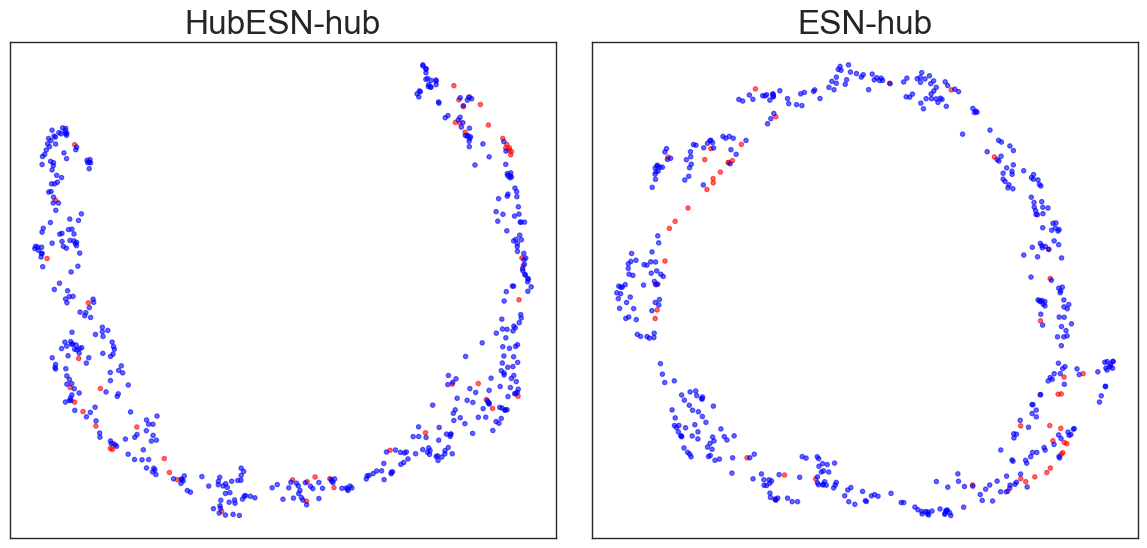

In [243]:
esn_pm = {
    'lr': 0.5,
    'p2': 0.2,
    'r_sig': 0.1,
    'n_size': 500,
    'spec_rad': 0.9,
    'in_features': 1,
    'in_scale': 1,
    'activation': 'tanh',
    'input_neurons': 'hub',
    'hub_type': 'mix',
    'use_skip': False,
    'verbose': False,
    'lambda_dc': 0.5,
    'lambda_sc': 0.5,
    'exp_coef': 2,
}

task_pm = {
    'n_train': 2000,
    'n_test': 2000,
}
mg = MackeyGlass(**task_pm)

esn_states, esn_deg = get_umap('esn', mg, esn_pm)
hub_states, hub_deg = get_umap('hubesn', mg, esn_pm)

plot_umap(hub_states, hub_deg, esn_states, esn_deg, esn_pm)

In [3]:
from sklearn.svm import LinearSVR
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression, Ridge

def separability(model, task, params):
    states, deg = get_averaged_states(model, task, params, False, 20)
    train_idx = np.random.choice(params['n_size'], size=int(params['n_size']*0.8), replace=False)
    test_idx = np.array([i for i in range(params['n_size']) if i not in train_idx])

    # get linear separability
    # regr = MLPRegressor(hidden_layer_sizes=(100, 100), max_iter=10000, tol=1e-6, verbose=False)
    # regr.fit(scaled_states[:, train_idx].T, deg[train_idx])
    # regr = LinearRegression()
    # regr.fit(scaled_states[:, train_idx].T, deg[train_idx])
    # regr = Ridge(alpha=0.1)
    # regr.fit(scaled_states[:, train_idx].T, deg[train_idx])
    regr = LinearSVR()
    regr.fit(states[:, train_idx].T, deg[train_idx])
    
    return regr.predict(states[:, test_idx].T), deg[test_idx]
    # return cross_val_score(clf, scaled_states.T, deg, cv=5, scoring='r2')


esn_pm = {
    'lr': 0.5,
    'p2': 0.2,
    'r_sig': 0.1,
    'n_size': 1000,
    'spec_rad': 0.9,
    'in_features': 1,
    'in_scale': 1,
    'activation': 'tanh',
    'input_neurons': 'hub',
    'hub_type': 'mix',
    'use_skip': False,
    'verbose': False,
    'lambda_dc': 0.5,
    'lambda_sc': 0.5,
    'exp_coef': 2,
}

task_pm = {
    'n_train': 2000,
    'n_test': 5000,
}
mg = MackeyGlass(**task_pm)

esn_pred, esn_deg = separability('esn', mg, esn_pm)
hub_pred, hub_deg = separability('hubesn', mg, esn_pm)

NameError: name 'get_averaged_states' is not defined

In [ ]:
print(((esn_pred - esn_deg)**2).mean())
print(((hub_pred - hub_deg)**2).mean())

121.78122205015018
77701.27503790622


In [4]:
def plot_separability(hub_pred, hub_deg, esn_pred, esn_deg, params):
    alpha = 1
    size = 20
    
    # begin plotting
    sns.set_style('white')
    sns.set_context('paper', font_scale=2.5)
    sns.set_color_codes("bright")
    colors = sns.color_palette("Set2")
    
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(121)
    ax.scatter(hub_pred, hub_deg, s=size, alpha=alpha, c=colors[0])
    ax.set_title(f"HubESN-{params['input_neurons']}")
    ax.set_xlabel("Predicted Degree")
    ax.set_ylabel("True Degree")
    ax = fig.add_subplot(122)
    ax.scatter(esn_pred, esn_deg, s=size, alpha=alpha, c=colors[2])
    ax.set_title(f"ESN-{params['input_neurons']}")
    ax.set_xlabel("Predicted Degree")
    ax.set_ylabel("True Degree")
    plt.tight_layout()
    plt.savefig(f"{PLTPATH}/separability_{params['input_neurons']}.jpg", dpi=300)
    plt.show()

plot_separability(hub_pred, hub_deg, esn_pred, esn_deg, esn_pm)

NameError: name 'hub_pred' is not defined